In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import scanpy as sc
import torch
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Download Dataset and split into reference dataset and query dataset

In [4]:
adata = sc.read('pbmc_vars_sb.h5ad')

In [5]:
adata = adata[adata.obs['study']!='Villani'].copy()

In [6]:
adata.X = adata.layers["counts"].copy()

In [7]:
sca.add_annotations(adata, 'c2.cp.reactome.v4.0.symbols.gmt', min_genes=12)

In [8]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [9]:
sc.pp.normalize_total(adata)

In [10]:
sc.pp.log1p(adata)

In [11]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [12]:
select_terms = adata.varm['I'].sum(0)>12

In [13]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [14]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [15]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [16]:
adata.X = adata.layers["counts"].copy()

### Create TRVAE model and train it on reference dataset

In [17]:
intr_cvae = sca.models.TRVAE(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[256, 256, 256],
    use_mmd=False,
    recon_loss='nb',
    mask=adata.varm['I'].T,
    use_decoder_relu=False,
    mmd_instead_kl=False
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 4
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
Decoder Architecture:
	Masked linear layer in, out and cond:  282 1972 4


In [18]:
ALPHA = 0.7

In [19]:
OMEGA = None

In [20]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA, 
    omega=OMEGA,
    alpha_kl=0.5,
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    seed=2020
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |█████████-----------| 47.8%  - epoch_loss:  869.66 - epoch_recon_loss:  844.94 - epoch_kl_loss:   49.43 - val_loss:  936.64 - val_recon_loss:  911.32 - val_kl_loss:   50.63
ADJUSTED LR
 |██████████----------| 51.5%  - epoch_loss:  872.38 - epoch_recon_loss:  847.49 - epoch_kl_loss:   49.78 - val_loss:  931.37 - val_recon_loss:  905.99 - val_kl_loss:   50.77
ADJUSTED LR
 |██████████----------| 54.8%  - epoch_loss:  873.97 - epoch_recon_loss:  849.13 - epoch_kl_loss:   49.68 - val_loss:  929.62 - val_recon_loss:  904.32 - val_kl_loss:   50.60
ADJUSTED LR
 |███████████---------| 58.0%  - epoch_loss:  870.09 - epoch_recon_loss:  845.29 - epoch_kl_loss:   49.60 - val_loss:  932.20 - val_recon_loss:  906.83 - val_kl_loss:   50.74
ADJUSTED LR
 |████████████--------| 60.8%  - epoch_loss:  870.81 - epoch_recon_loss:  846.01 - epoch_kl_loss:   49.60 - val_loss:  933.59 - val_recon_loss:  908.16 - val_kl_loss:   50.85
Stopping early: no improvement of more than 0 nats in 50 epochs
If the early 

In [21]:
inactive_idx = ~(intr_cvae.model.decoder.L0.expr_L.weight.data.norm(p=2, dim=0)>0).cpu().numpy()

In [22]:
print('Inactive terms:')
[term for i, term in enumerate(adata.uns['terms']) if inactive_idx[i]]

Inactive terms:


['PYRUVATE_METABOLISM_AND_CITRIC',
 'GROWTH_HORMONE_RECEPTOR_SIGNAL',
 'SPHINGOLIPID_DE_NOVO_BIOSYNTHE',
 'NUCLEAR_SIGNALING_BY_ERBB4',
 'RIP_MEDIATED_NFKB_ACTIVATION_V',
 'RORA_ACTIVATES_CIRCADIAN_EXPRE',
 'YAP1_AND_WWTR1_TAZ_STIMULATED_',
 'EXTRACELLULAR_MATRIX_ORGANIZAT',
 'CIRCADIAN_REPRESSION_OF_EXPRES',
 'TRIGLYCERIDE_BIOSYNTHESIS',
 'SMAD2_SMAD3_SMAD4_HETEROTRIMER',
 'TGF_BETA_RECEPTOR_SIGNALING_AC',
 'DOWNREGULATION_OF_SMAD2_3_SMAD',
 'PHASE1_FUNCTIONALIZATION_OF_CO',
 'CA_DEPENDENT_EVENTS',
 'INTEGRIN_ALPHAIIB_BETA3_SIGNAL',
 'P53_DEPENDENT_G1_DNA_DAMAGE_RE',
 'GLUCAGON_SIGNALING_IN_METABOLI',
 'CLASS_B_2_SECRETIN_FAMILY_RECE',
 'FORMATION_OF_RNA_POL_II_ELONGA',
 'G_BETA_GAMMA_SIGNALLING_THROUG',
 'CD28_DEPENDENT_PI3K_AKT_SIGNAL',
 'G_PROTEIN_BETA_GAMMA_SIGNALLIN',
 'CTLA4_INHIBITORY_SIGNALING',
 'SIGNAL_AMPLIFICATION',
 'SMOOTH_MUSCLE_CONTRACTION',
 'ACTIVATION_OF_KAINATE_RECEPTOR',
 'EFFECTS_OF_PIP2_HYDROLYSIS',
 'RNA_POL_I_PROMOTER_OPENING',
 'REGULATION_OF_SIGNALING_BY_CBL

In [23]:
MEAN = False

In [24]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [25]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [26]:
sc.tl.umap(adata)

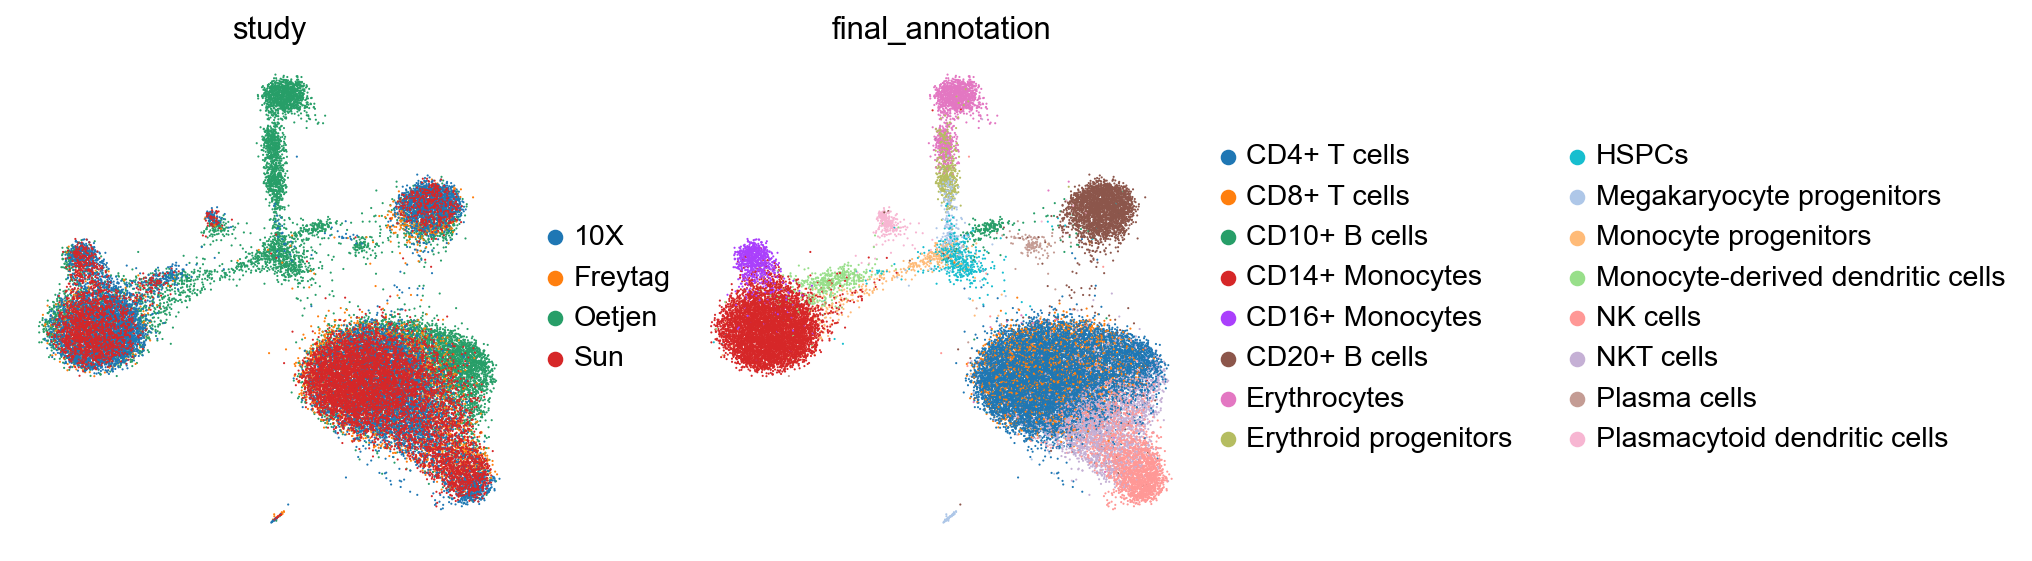

In [27]:
sc.pl.umap(adata, color=['study', 'final_annotation'], frameon=False)

In [28]:
#intr_cvae.save('intr_cvae_nb_mmd_beta_15')

In [29]:
kang = sc.read('kang_count.h5ad')[:, adata.var_names].copy()

In [30]:
kang.obs['study'] = 'Kang'

In [31]:
#q_intr_cvae = sca.models.TRVAE.load('q_intr_cvae_nb_alpha_kl_0_001_sd_2021', kang)

In [66]:
q_intr_cvae = sca.models.TRVAE.load_query_data(kang, intr_cvae)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 5
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
Decoder Architecture:
	Masked linear layer in, out and cond:  282 1972 5


In [67]:
q_intr_cvae.train(n_epochs=400, alpha_epoch_anneal=100, weight_decay=0., alpha_kl=0.1, seed=2020, use_early_stopping=True)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |████████████████████| 100.0%  - epoch_loss:  518.89 - epoch_recon_loss:  511.94 - epoch_kl_loss:   69.48 - val_loss:  523.41 - val_recon_loss:  516.46 - val_kl_loss:   69.49


In [68]:
#q_intr_cvae.save('q_intr_cvae_nolog_alpha_kl_0_5_0_1_sd_2020')

In [69]:
kang.obsm['X_cvae'] = q_intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [70]:
sc.pp.neighbors(kang, use_rep='X_cvae')

In [71]:
sc.tl.umap(kang)

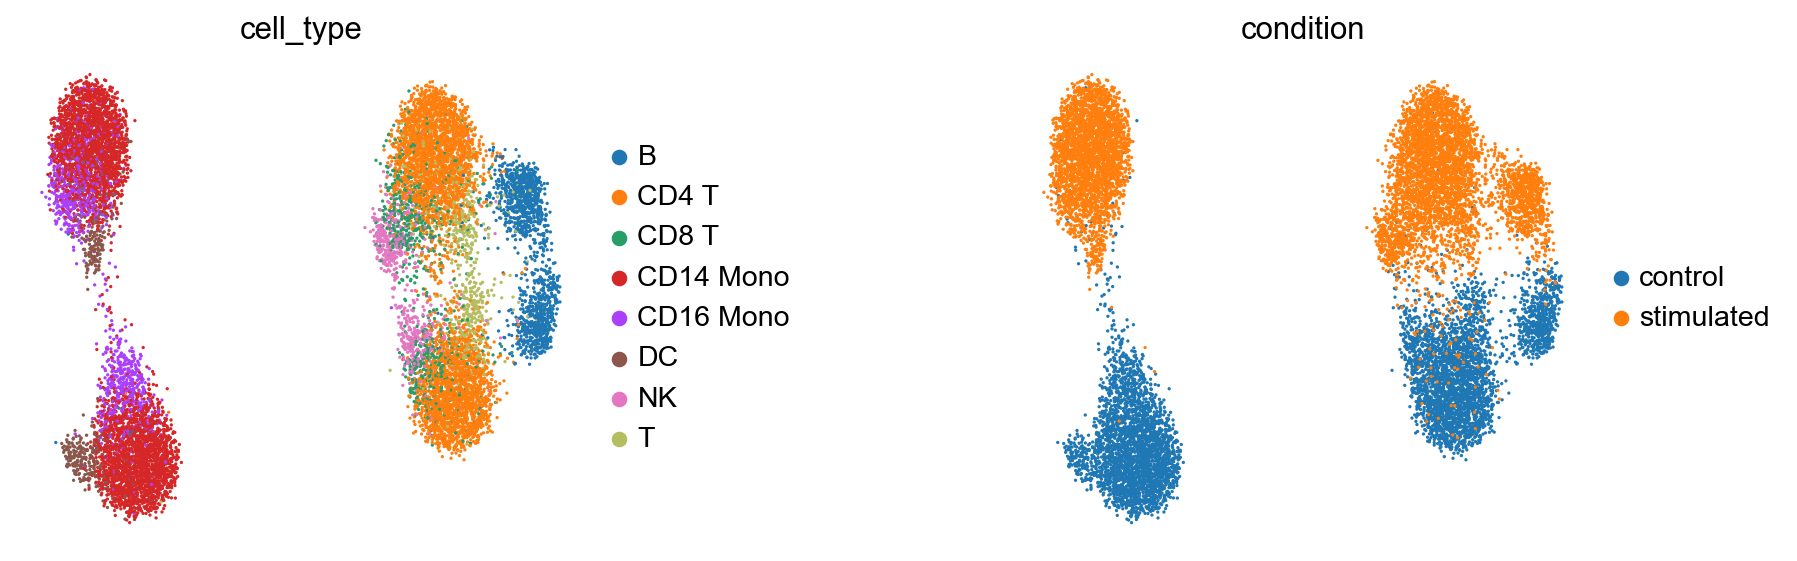

In [72]:
sc.pl.umap(kang, color=['cell_type', 'condition'], frameon=False, wspace=0.6)

In [73]:
terms = adata.uns['terms']

In [74]:
terms

['TRANSLATION',
 'PYRUVATE_METABOLISM_AND_CITRIC',
 'APOPTOTIC_CLEAVAGE_OF_CELLULAR',
 'FORMATION_OF_THE_TERNARY_COMPL',
 'SIGNALING_BY_RHO_GTPASES',
 'SIGNALING_BY_WNT',
 'SIGNALLING_BY_NGF',
 'SIGNALING_BY_SCF_KIT',
 'DEVELOPMENTAL_BIOLOGY',
 'DAG_AND_IP3_SIGNALING',
 'TCA_CYCLE_AND_RESPIRATORY_ELEC',
 'BMAL1_CLOCK_NPAS2_ACTIVATES_CI',
 'ANTIGEN_PROCESSING_CROSS_PRESE',
 'GROWTH_HORMONE_RECEPTOR_SIGNAL',
 'TRIF_MEDIATED_TLR3_SIGNALING',
 'CELL_CELL_COMMUNICATION',
 'ER_PHAGOSOME_PATHWAY',
 'MEIOSIS',
 'MEMBRANE_TRAFFICKING',
 'NEF_MEDIATES_DOWN_MODULATION_O',
 'IMMUNOREGULATORY_INTERACTIONS_',
 'METABOLISM_OF_VITAMINS_AND_COF',
 'TRANS_GOLGI_NETWORK_VESICLE_BU',
 'CELL_CYCLE',
 'SIGNALING_BY_ERBB4',
 'ORC1_REMOVAL_FROM_CHROMATIN',
 'O_LINKED_GLYCOSYLATION_OF_MUCI',
 'ANTIVIRAL_MECHANISM_BY_IFN_STI',
 'SIGNALING_BY_ERBB2',
 'SPHINGOLIPID_DE_NOVO_BIOSYNTHE',
 'SIGNALING_BY_EGFR_IN_CANCER',
 'SRP_DEPENDENT_COTRANSLATIONAL_',
 'PI3K_EVENTS_IN_ERBB4_SIGNALING',
 'PI3K_EVENTS_IN_ERBB2_SIGN

In [75]:
idx = [terms.index(term) for term in ['INTERFERON_SIGNALING', 'SIGNALING_BY_THE_B_CELL_RECEPT', 'INTERFERON_ALPHA_BETA_SIGNALIN']]

In [76]:
latents = q_intr_cvae.get_latent(mean=MEAN)[:, idx]

In [77]:
kang.obs['INTERFERON_SIGNALING'] = latents[:, 0]
kang.obs['SIGNALING_BY_THE_B_CELL_RECEPT'] = latents[:, 1]
kang.obs['INTERFERON_ALPHA_BETA_SIGNALIN'] = latents[:, 2]

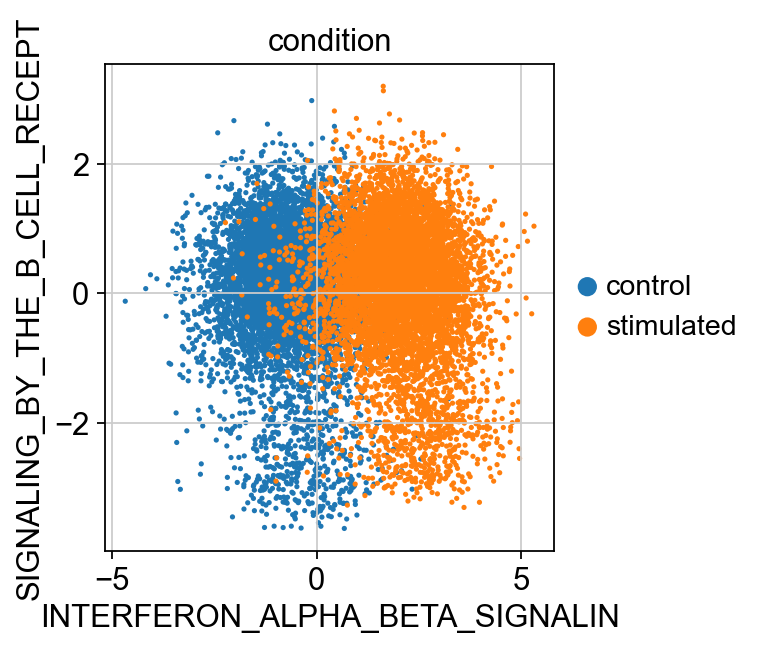

In [78]:
sc.pl.scatter(kang, x='INTERFERON_ALPHA_BETA_SIGNALIN', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='condition', size=22)

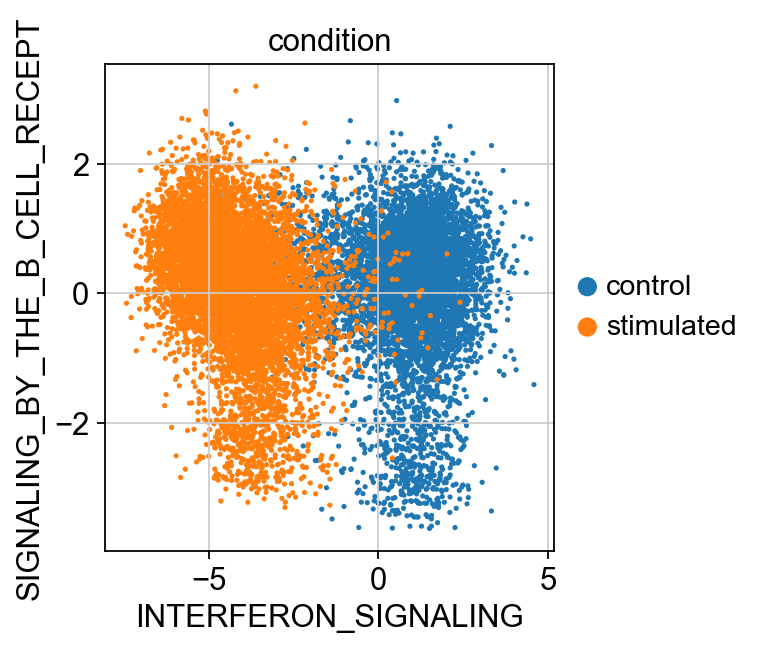

In [79]:
sc.pl.scatter(kang, x='INTERFERON_SIGNALING', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='condition', size=22)

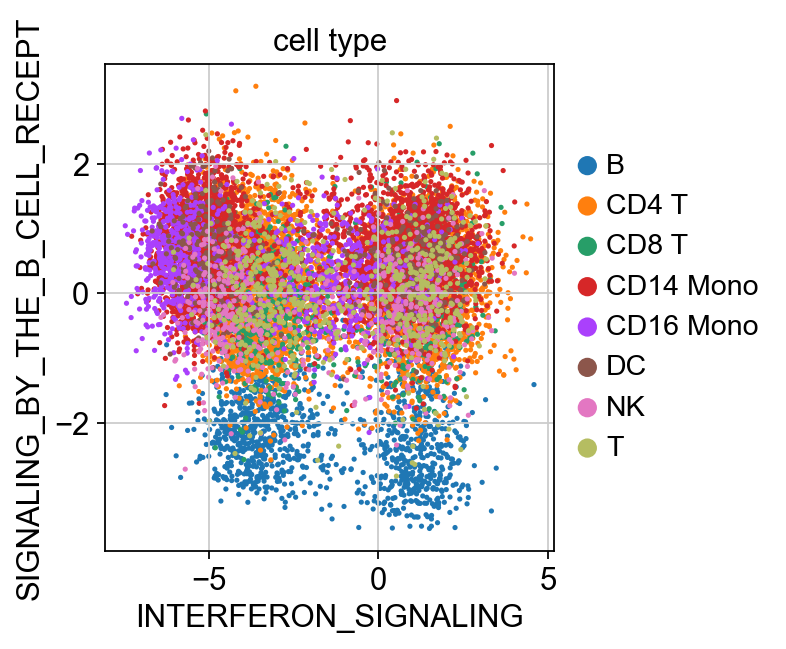

In [80]:
sc.pl.scatter(kang, x='INTERFERON_SIGNALING', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='cell_type', size=22)

In [81]:
latents = intr_cvae.get_latent(mean=MEAN)[:, idx]

In [82]:
adata.obs['INTERFERON_SIGNALING'] = latents[:, 0]
adata.obs['SIGNALING_BY_THE_B_CELL_RECEPT'] = latents[:, 1]

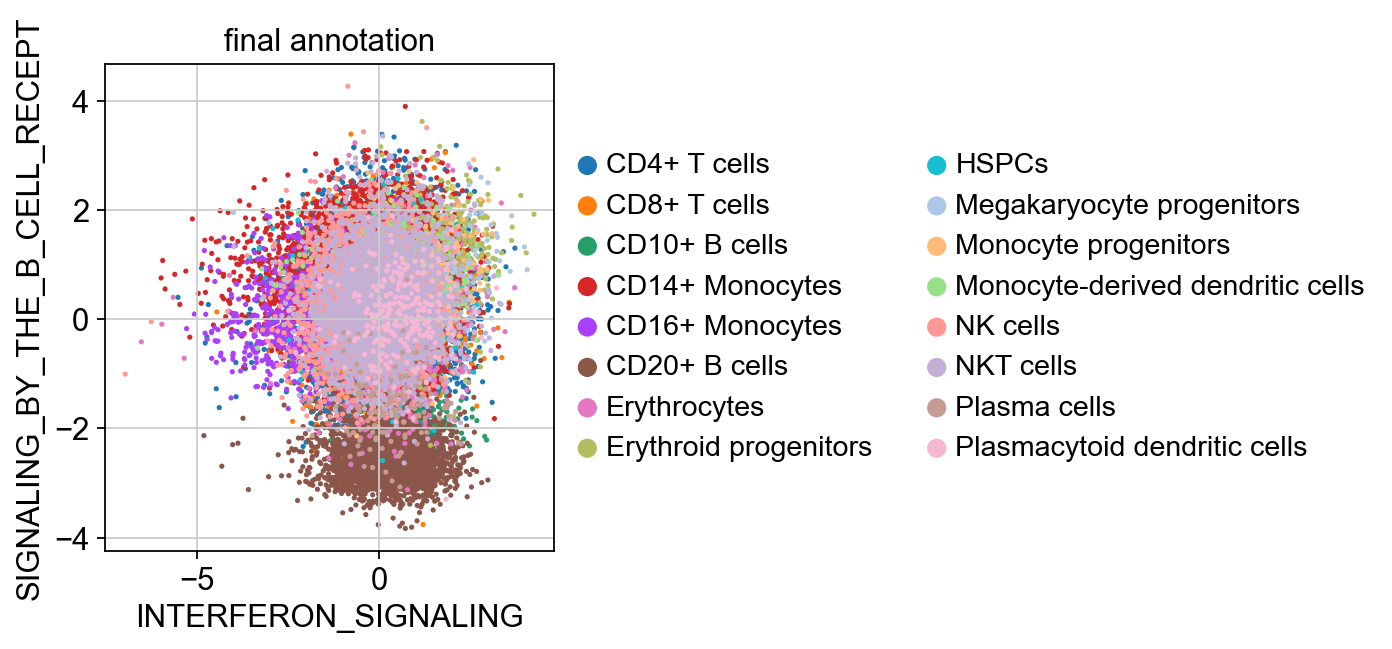

In [83]:
sc.pl.scatter(adata, x='INTERFERON_SIGNALING', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='final_annotation', size=22)

In [84]:
kang_pbmc = sc.AnnData.concatenate(adata, kang, batch_key='batch_join')

In [85]:
kang_pbmc.obsm['X_cvae'] = q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'].tolist(), mean=MEAN)[:, ~inactive_idx]

In [86]:
sc.pp.neighbors(kang_pbmc, use_rep='X_cvae')
sc.tl.umap(kang_pbmc)

In [87]:
kang_pbmc.strings_to_categoricals()

... storing 'batch' as categorical
... storing 'chemistry' as categorical
... storing 'data_type' as categorical
... storing 'final_annotation' as categorical
... storing 'sample_ID' as categorical
... storing 'species' as categorical
... storing 'study' as categorical
... storing 'tissue' as categorical
... storing 'orig.ident' as categorical
... storing 'stim' as categorical
... storing 'seurat_annotations' as categorical
... storing 'condition' as categorical
... storing 'cell_type' as categorical


In [88]:
kang_pbmc.obs['cell_type_joint'] = kang_pbmc.obs['final_annotation'].tolist()

In [89]:
idx_1 = kang_pbmc.obs['cell_type_joint'].astype(str) == 'nan'
idx_2 = kang_pbmc.obs['cell_type'].astype(str) != 'nan'
kang_pbmc.obs['cell_type_joint'][idx_1] = kang_pbmc.obs['cell_type'][idx_2].tolist()

In [90]:
categories = np.unique(kang_pbmc.obs['cell_type_joint'])

In [91]:
categories

array(['B', 'CD10+ B cells', 'CD14 Mono', 'CD14+ Monocytes', 'CD16 Mono',
       'CD16+ Monocytes', 'CD20+ B cells', 'CD4 T', 'CD4+ T cells',
       'CD8 T', 'CD8+ T cells', 'DC', 'Erythrocytes',
       'Erythroid progenitors', 'HSPCs', 'Megakaryocyte progenitors',
       'Monocyte progenitors', 'Monocyte-derived dendritic cells', 'NK',
       'NK cells', 'NKT cells', 'Plasma cells',
       'Plasmacytoid dendritic cells', 'T'], dtype=object)

In [92]:
celltypes_replace = {}
celltypes_replace['CD20+ B cells'] = 'B'
celltypes_replace['CD4 T'] = 'CD4+ T cells'
celltypes_replace['CD8 T'] = 'CD8+ T cells'
celltypes_replace['CD14 Mono'] = 'CD14+ Monocytes'
celltypes_replace['CD16 Mono'] = 'CD16+ Monocytes'
celltypes_replace['NK'] = 'NK cells'

In [93]:
for cat in categories:
    if cat in celltypes_replace:
        kang_pbmc.obs['cell_type_joint'][kang_pbmc.obs['cell_type_joint']==cat] = celltypes_replace[cat]

... storing 'cell_type_joint' as categorical


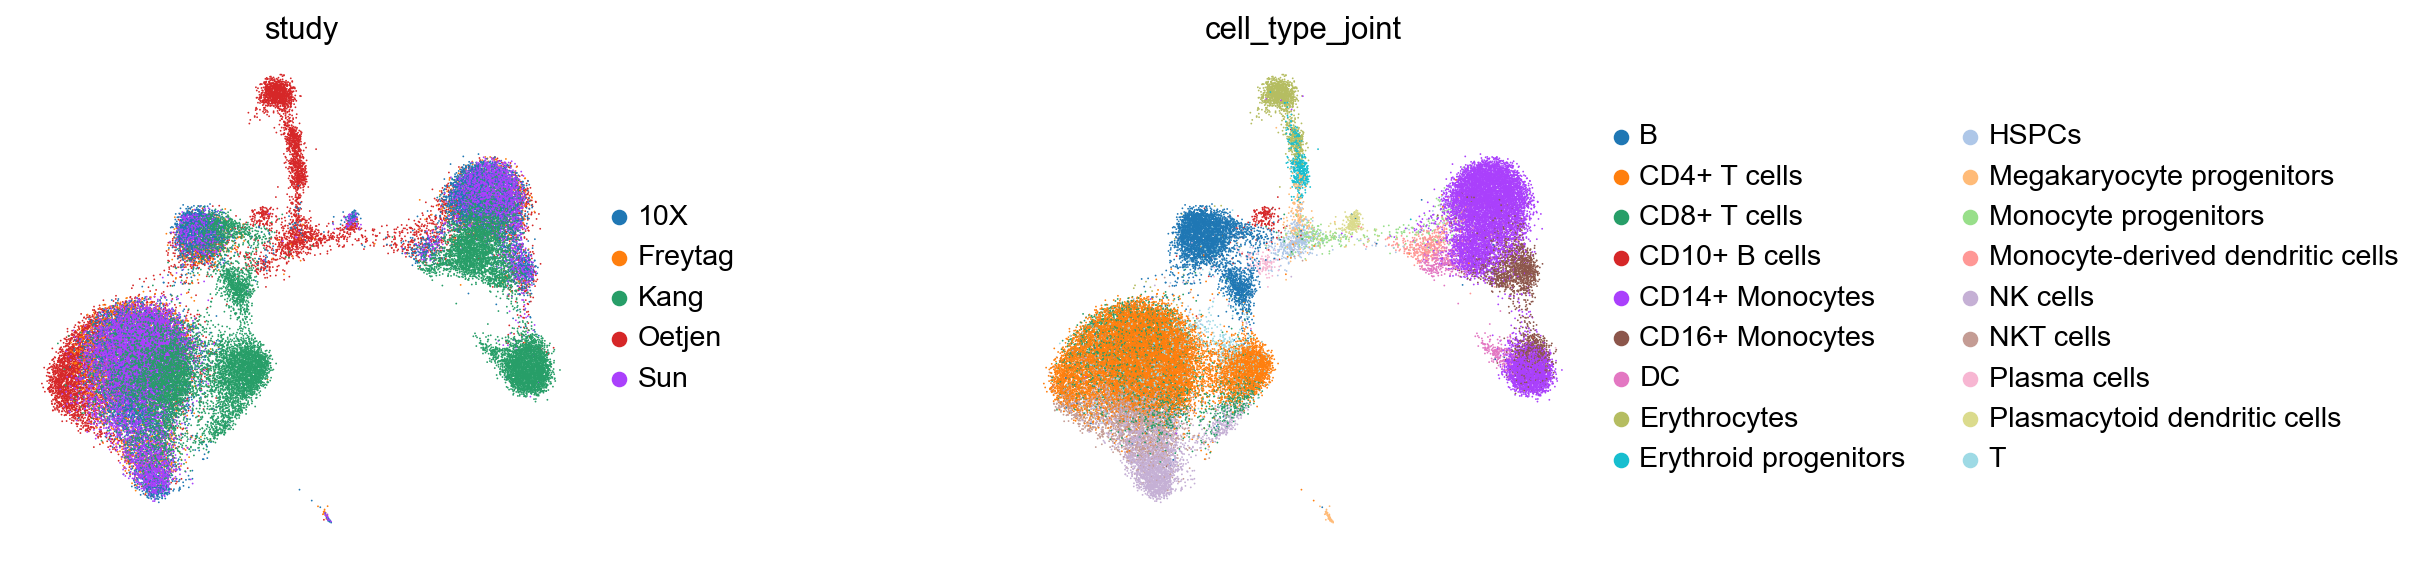

In [94]:
sc.pl.umap(kang_pbmc, color=['study', 'cell_type_joint'], frameon=False, wspace=0.6)

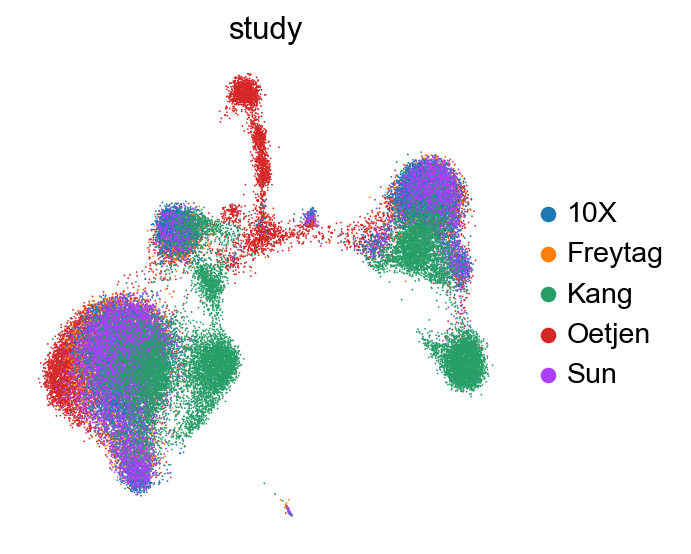

In [95]:
sc.pl.umap(kang_pbmc, color='study', frameon=False, wspace=0.6)

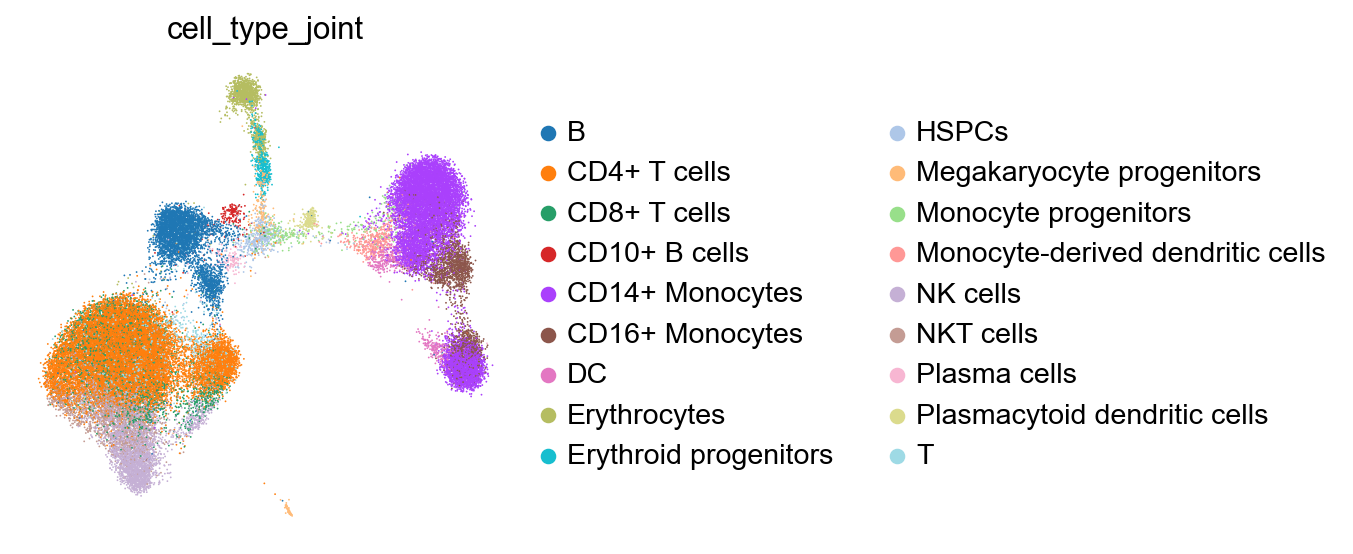

In [96]:
sc.pl.umap(kang_pbmc, color='cell_type_joint', frameon=False, wspace=0.6)

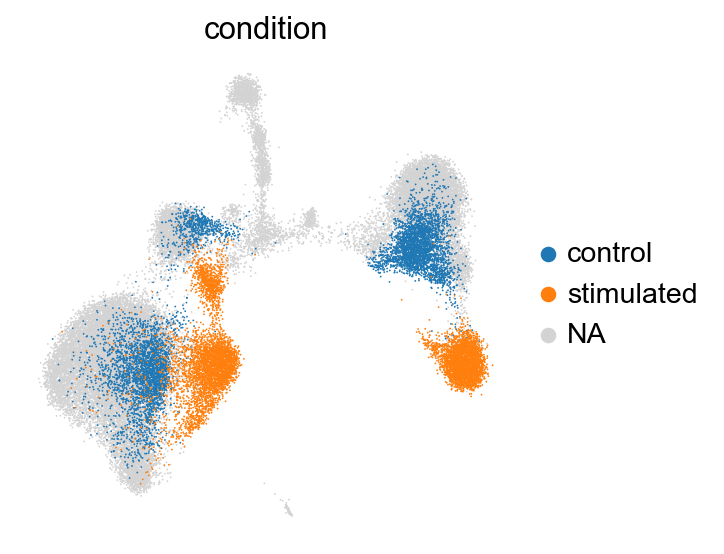

In [97]:
sc.pl.umap(kang_pbmc, color='condition', frameon=False, wspace=0.6)

In [99]:
kang_pbmc.uns['terms'] = adata.uns['terms']

In [100]:
#kang_pbmc.write('kang_pbmc_integrated.h5ad')

In [ ]:
latents = q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'], mean=MEAN)[:, idx]

In [ ]:
kang_pbmc.obs['INTERFERON_SIGNALING'] = latents[:, 0]
kang_pbmc.obs['SIGNALING_BY_THE_B_CELL_RECEPT'] = latents[:, 1]
kang_pbmc.obs['INTERFERON_ALPHA_BETA_SIGNALIN'] = latents[:, 2]

In [ ]:
sc.pl.scatter(kang_pbmc, x='INTERFERON_ALPHA_BETA_SIGNALIN', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='condition', size=22)

In [ ]:
sc.pl.scatter(kang_pbmc, x='INTERFERON_SIGNALING', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='condition', size=22)

In [ ]:
sc.pl.scatter(kang_pbmc, x='INTERFERON_SIGNALING', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='cell_type_joint', size=22)

In [ ]:
#scvi

In [20]:
sca.dataset.setup_anndata(adata, batch_key="study")

INFO     Using batches from adata.obs["study"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 32484 cells, 1972 vars, 4 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [21]:
vae = sca.models.SCVI(
    adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [22]:
vae.train(max_epochs=500, early_stopping=True)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Epoch 317/500:  63%|█████████████████████████████▏                | 317/500 [31:44<18:19,  6.01s/it, loss=892, v_num=1]


In [23]:
vae_q = sca.models.SCVI.load_query_data(kang, vae, freeze_dropout=True)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 13576 cells, 1972 vars, 5 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


In [24]:
vae_q.train(max_epochs=500, early_stopping=True, plan_kwargs=dict(weight_decay=0.0))

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Epoch 500/500: 100%|██████████████████████████████████████████████| 500/500 [14:56<00:00,  1.79s/it, loss=654, v_num=1]


In [26]:
kang_pbmc = sc.read('kang_pbmc.h5ad')

In [27]:
X_scvi = vae_q.get_latent_representation(kang_pbmc)

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 46060 cells, 1972 vars, 5 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


In [30]:
kang_pbmc.obsm['X_scvi'] = X_scvi

In [32]:
sc.pp.neighbors(kang_pbmc, use_rep='X_scvi')
sc.tl.umap(kang_pbmc)

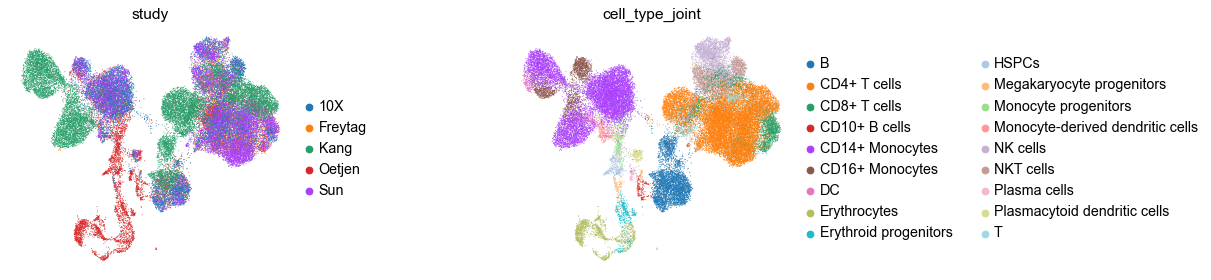

In [33]:
sc.pl.umap(kang_pbmc, color=['study', 'cell_type_joint'], frameon=False, wspace=0.6)

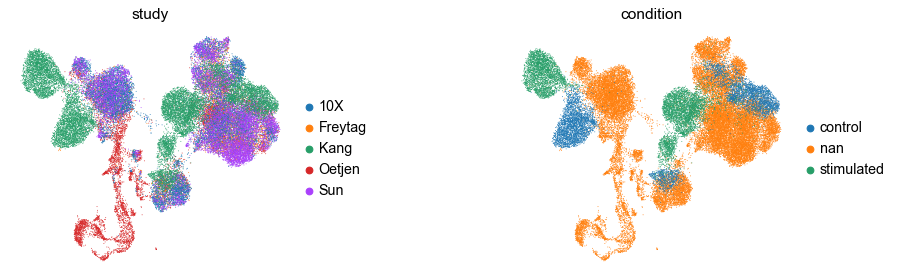

In [34]:
sc.pl.umap(kang_pbmc, color=['study', 'condition'], frameon=False, wspace=0.6)

In [36]:
pbmc = kang_pbmc[kang_pbmc.obs['study']!='Kang']

In [47]:
sc.pp.neighbors(pbmc, use_rep='X_scvi')
sc.tl.umap(pbmc)

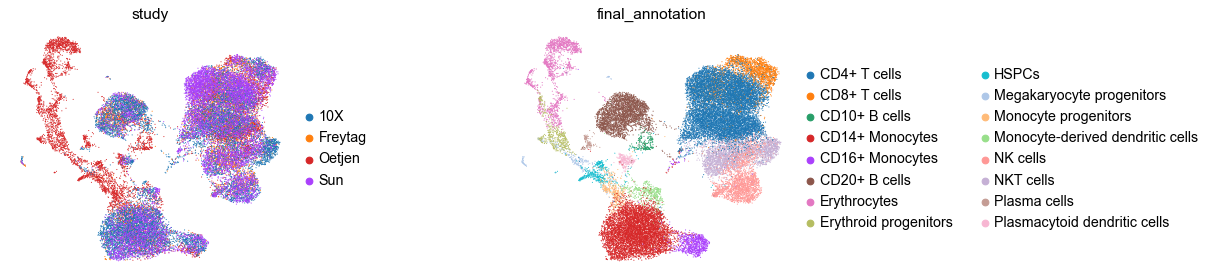

In [43]:
sc.pl.umap(pbmc, color=['study', 'final_annotation'], frameon=False, wspace=0.6)

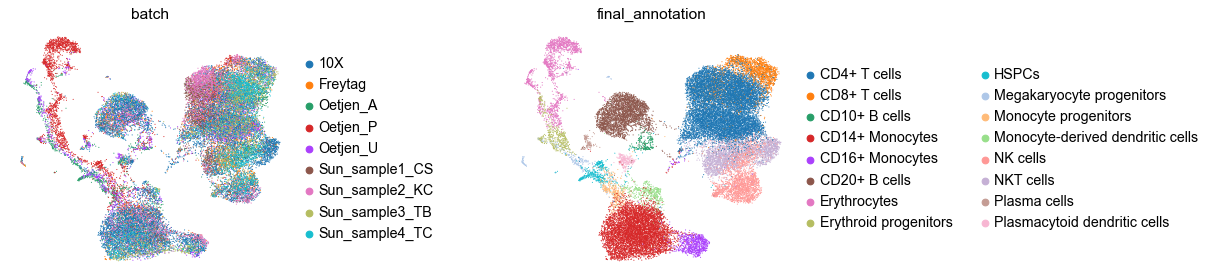

In [48]:
sc.pl.umap(pbmc, color=['batch', 'final_annotation'], frameon=False, wspace=0.6)

In [49]:
sc.pp.neighbors(pbmc, use_rep='X_cvae')
sc.tl.umap(pbmc)

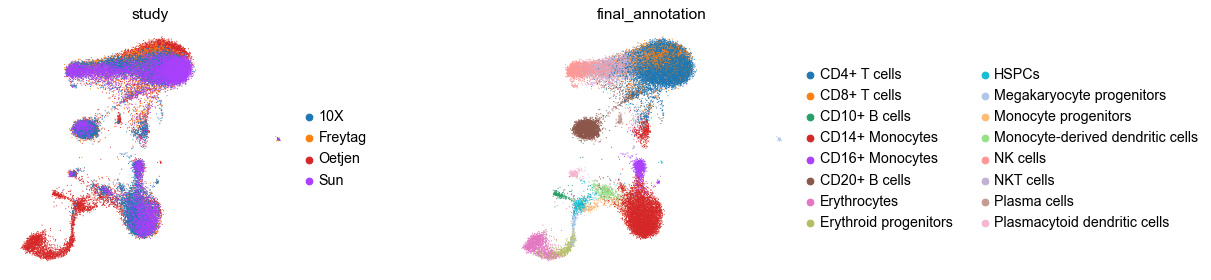

In [45]:
sc.pl.umap(pbmc, color=['study', 'final_annotation'], frameon=False, wspace=0.6)

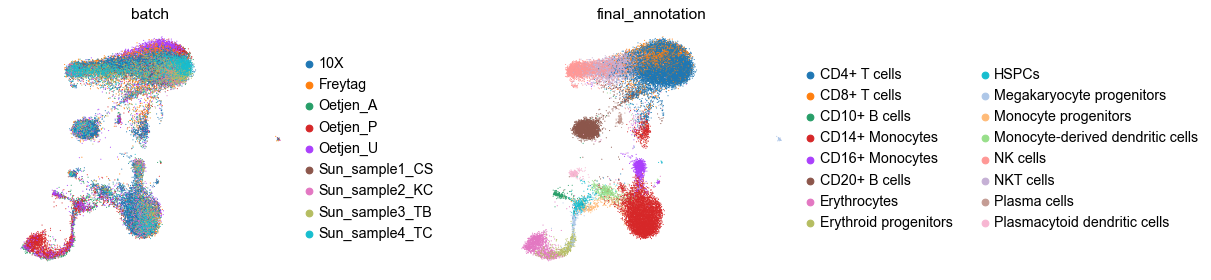

In [50]:
sc.pl.umap(pbmc, color=['batch', 'final_annotation'], frameon=False, wspace=0.6)

In [35]:
kang_pbmc.write('kang_pbmc.h5ad')